# Laboratorium 4

### Konfiguracja

In [229]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [230]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


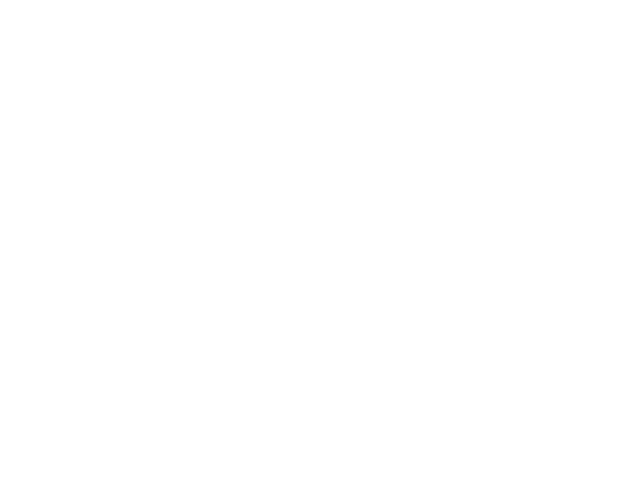

In [231]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


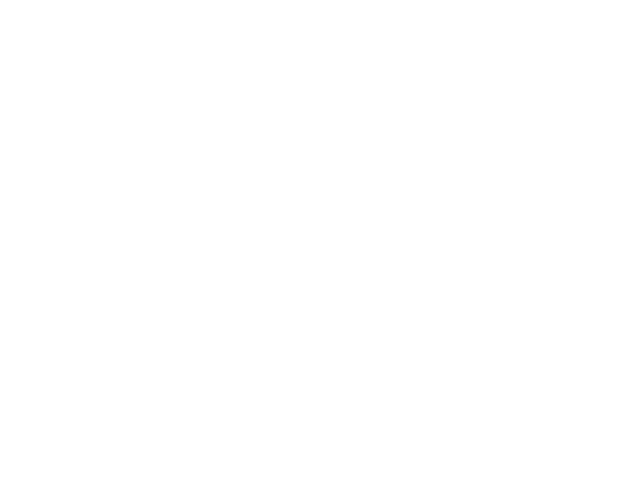

In [232]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


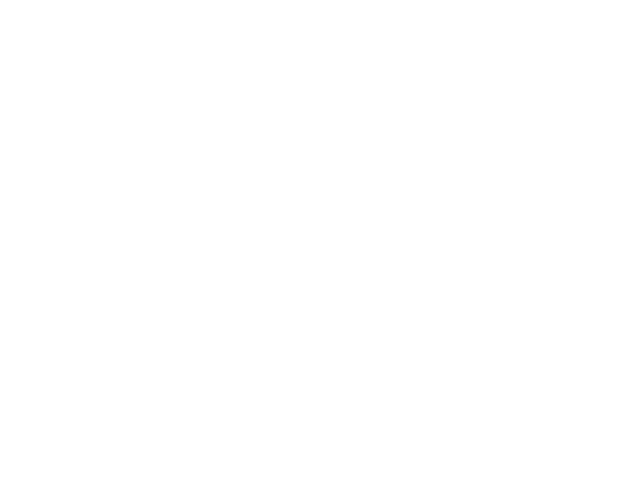

In [233]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [234]:
# plot2 = Plot([plot1.get_added_elements()])

# print(plot1.get_added_figure()[0].lines)

# plot2.draw()

### Rozwiązanie

#### Data classes

In [235]:
from enum import Enum
from enum import auto

class Point:
    def __init__(self, x , y):
        self.x = x
        self.y = y
        self.type = None
    
    def to_tuple(self):
        return self.x, self.y
    
    def __str__(self):
        return f"{[self.x, self.y]}"
    
    def set_vertex_type(self, vertex_type):
        self.type = vertex_type
        
    def get_color(self):
        if self.type is None:
           return 'black'
        else:
            return self.type.value
    
### Points ordered counter-clockwise
class Polygon:
    def __init__(self, points):
        self.points = points
        
    def __len__(self):
        return len(self.points)
    
    def prev(self, i):
        return self.points[(i - 1) % len(self.points)]
    
    def next(self, i):
        return self.points[(i + 1) % len(self.points)]
    
    def get_scene(self):
        start, end, conn, div, corr = [], [], [], [], [] 
        others = []
        
        for point in self.points:
            if point.type == VertexType.START:
                start.append(point.to_tuple())
            elif point.type == VertexType.END:
                end.append(point.to_tuple())
            elif point.type == VertexType.CONNECTING:
                conn.append(point.to_tuple())
            elif point.type == VertexType.DIVIDING:
                div.append(point.to_tuple())
            elif point.type == VertexType.CORRECT:
                corr.append(point.to_tuple())
            else:
                others.append(point.to_tuple())
                
        lines = []
        
        for i, current in enumerate(self.points):
            nxt = self.next(i)
            lines.append([current.to_tuple(), nxt.to_tuple()])
        
        return Scene([
            PointsCollection(start, color= VertexType.START.value),
            PointsCollection(end, color = VertexType.END.value),
            PointsCollection(conn, color = VertexType.CONNECTING.value),
            PointsCollection(div, color = VertexType.DIVIDING.value),
            PointsCollection(corr, color = VertexType.CORRECT.value),
            PointsCollection(others, color = VertexType.CORRECT.value)
        ], [LinesCollection(lines, color = 'black')])
        
class VertexType(Enum):
    START = 'green'
    END = 'red'
    CONNECTING = 'purple'
    DIVIDING = 'blue'
    CORRECT = 'brown'
    
class Orientation(Enum):
    LEFT = auto()
    COLLINEAR = auto()
    RIGHT = auto()
    

### Few helper functions:
- det 
- orient
- comparator

In [236]:
eps = 10 ** (-9)

def det(a,b,c):
    return a.x * b.y + a.y * c.x + b.x * c.y - b.y * c.x - a.y * b.x - a.x * c.y

def orient(a, b, c):
    determinant = det(a, b, c)
    
    if determinant < -eps:
        return Orientation.RIGHT
    elif determinant > eps:
        return Orientation.LEFT
    else:
        return Orientation.COLLINEAR

def comparator(this, that):
    if this < that:
        return -1
    elif this == that:
        return 0
    else:
        return 1

def reversed_comparator(this, that):
    return - comparator(this, that)

def find_min(lst, key = lambda e: e, cmp = comparator):
    index, min_val = 0, key(lst[0])
    
    for i, e in enumerate(lst):
        if cmp(min_val, key(e)) > 0:
            index, min_val = i, key(e)
            
    return index, lst[index]

def find_uppermost(points):
    return find_min(points, lambda pnt: pnt.y, reversed_comparator)
            
def find_lowermost(points):
    return find_min(points, lambda pnt: pnt.y)

### Check whether given polygon is y-monotonic

In [237]:
def is_y_monotonic(polygon: Polygon):
    start_index, max_p = find_uppermost(polygon.points)
    end_index, min_p = find_lowermost(polygon.points)
    points = polygon.points
    
    ### Increment to go left, decrement to go right
    flag = True
    prev = start_index
    left_i = (prev + 1) % len(polygon)
    
    ### Check left branch
    while flag and left_i != end_index:
        if points[prev].y < points[left_i].y:
            flag = False
            
        prev = left_i
        left_i = (left_i + 1) % len(polygon)
       
    
    prev = start_index
    right_i = (prev - 1) % len(polygon)
    
    ### Check right branch
    while flag and right_i != end_index:
        if points[prev].y < points[right_i].y:
            flag = False
    
        prev = right_i
        right_i = (right_i - 1) % len(polygon)
    
    return flag

### Classifying vertices

In [238]:
def classify_vertices(polygon: Polygon):
    
    for i, current in enumerate(polygon.points):
        prev = polygon.prev(i)
        next = polygon.next(i)
        
        type = classify_vertex(prev, current, next)
        current.set_vertex_type(type)
        

def classify_vertex(prev, current, nxt):
    d = det(prev, current, nxt)
        
    if d > 0 and prev.y < current.y and nxt.y < current.y: 
        return VertexType.START
    if d > 0 and prev.y > current.y and nxt.y > current.y:
        return VertexType.END
    if d < 0 and prev.y < current.y and nxt.y < current.y: 
        return VertexType.DIVIDING
    if d < 0 and prev.y < current.y and nxt.y < current.y: 
        return VertexType.CONNECTING
    else:
        return VertexType.CORRECT

### IO Functions
- read
- save

In [239]:
def read_polygon_from_file(test):
    with open(test, 'r') as file:
        json = file.read()
        
    test_plot = Plot(json = json)
    
    lines = test_plot.scenes[0].lines[0].lines
    points = parse_lines_to_points(lines)

    return Polygon(points)

def save_plot(test_name, plot):
    with open(test_name, 'w') as file:
        file.write(plot.toJson())

def parse_lines_to_points(lines):
    points = []
    
    for line in lines:
        point = Point(*line[0])
        points.append(point)
        
    return points

<IPython.core.display.Javascript object>


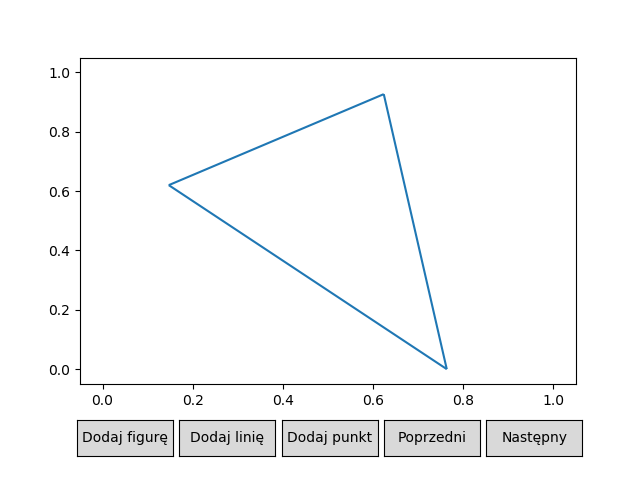

In [243]:
#Dodaj tu punkty, figury i/lub odcinki!
plot = Plot()
plot.draw()

True


<IPython.core.display.Javascript object>


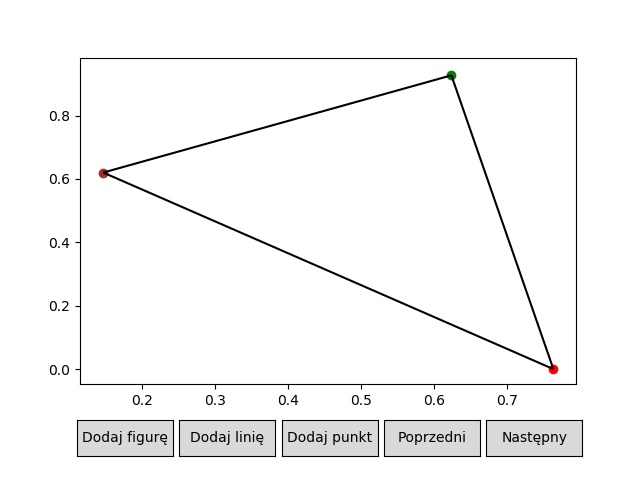

In [244]:
solution_plot = Plot([plot.get_added_elements()])
save_plot('test_1.json', solution_plot)

polygon = read_polygon_from_file('test_1.json')

print(is_y_monotonic(polygon))
classify_vertices(polygon)

plot = Plot([polygon.get_scene()])
plot.draw()